# Compare sea surface height model output and observations

Comparing the sea-surface height (ssh) from two different resolution runs. Specifically, we plot the time-mean and standard deviation of ssh and compare it to those obtained from observations from the CMEMS satellite altimetry dataset (former AVISO+ dataset).

In [1]:
import matplotlib.pyplot as plt
import intake
import numpy as np
import glob

import xarray as xr
import cartopy.crs as ccrs
import cmocean as cm

from dask.distributed import Client

In [2]:
catalog = intake.cat.access_nri

In [3]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 251.18 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34701,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 251.18 GiB
Comm: tcp://127.0.0.1:44489,Total threads: 4
Dashboard: /proxy/38189/status,Memory: 35.88 GiB
Nanny: tcp://127.0.0.1:35399,


## Start a cookbook database session

Here we pick a `start_time` and `end_time`. We select *only* 5 years of daily data for simplicity in this example. But you can probably extend the `end_time` until the end of 2018 (for model outputs) and up to middle of 2020 for observations!

In [4]:
#SSH variable in ACCESS-OM2 models
variable = 'sea_level'

start_time = '1993-01-01'
end_time = '1997-12-31'

## SSH from 1$^{\circ}$ model output

Here we can specify the rough start and end times using the `start_time` and `end_time` arguments. After we load them, we slice the data in time to ensure we have the same time range in all datasets we plan to compare.

In [5]:
experiment = '1deg_jra55_iaf_omip2_cycle6'  # 1-deg experiment
cat_subset = catalog[experiment]
var_search = cat_subset.search(variable=variable, frequency='1day')
ds = var_search.to_dask()
ssh1 = ds[variable].sel(time=slice(start_time, end_time))
ssh1

<xarray.DataArray 'sea_level' (time: 1826, yt_ocean: 300, xt_ocean: 360)> Size: 789MB
dask.array<getitem, shape=(1826, 300, 360), dtype=float32, chunksize=(1, 300, 360), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 3kB -279.5 -278.5 -277.5 ... 77.5 78.5 79.5
  * yt_ocean  (yt_ocean) float64 2kB -77.88 -77.63 -77.38 ... 88.87 89.32 89.77
  * time      (time) datetime64[ns] 15kB 1993-01-01T12:00:00 ... 1997-12-31T1...
Attributes:
    long_name:      effective sea level (eta_t + patm/(rho0*g)) on T cells
    units:          meter
    valid_range:    [-1000.  1000.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_surface_height_above_geoid

## SSH from 0.25$^{\circ}$ model output

In [6]:
experiment = '025deg_jra55_iaf_omip2_cycle6'  # 0.25-deg experiment
cat_subset = catalog[experiment]
var_search = cat_subset.search(variable=variable, frequency='1day')
ds = var_search.to_dask()
ssh025 = ds[variable].sel(time=slice(start_time, end_time))
ssh025

<xarray.DataArray 'sea_level' (time: 1826, yt_ocean: 1080, xt_ocean: 1440)> Size: 11GB
dask.array<getitem, shape=(1826, 1080, 1440), dtype=float32, chunksize=(1, 216, 240), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 12kB -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yt_ocean  (yt_ocean) float64 9kB -81.08 -80.97 -80.87 ... 89.74 89.84 89.95
  * time      (time) datetime64[ns] 15kB 1993-01-01T12:00:00 ... 1997-12-31T1...
Attributes:
    long_name:      effective sea level (eta_t + patm/(rho0*g)) on T cells
    units:          meter
    valid_range:    [-1000.  1000.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_surface_height_above_geoid

## CMEMS satellite observational data (former AVISO+ dataset)

Load the CMEMS dataset and select `adt` the sea surface height variable name.

**Note**: You **need** to join project `ua8` on NCI to access the CMEMS data!

In [7]:
filenames = glob.glob("/g/data/ua8/CMEMS_SeaLevel/timeseries/*.nc")
cmems = xr.open_mfdataset(filenames, parallel=True)

obs_ssh = cmems.adt
obs_ssh = obs_ssh.sel(time=slice(start_time, end_time))
obs_ssh = obs_ssh.rename('adt_cmems')
obs_ssh

<xarray.DataArray 'adt_cmems' (time: 1826, latitude: 720, longitude: 1440)> Size: 15GB
dask.array<getitem, shape=(1826, 720, 1440), dtype=float64, chunksize=(1, 45, 1440), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 15kB 1993-01-01 1993-01-02 ... 1997-12-31
  * longitude  (longitude) float32 6kB 0.125 0.375 0.625 ... 359.4 359.6 359.9
  * latitude   (latitude) float32 3kB -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
Attributes:
    standard_name:  sea_surface_height_above_geoid
    long_name:      Absolute dynamic topography
    units:          m
    grid_mapping:   crs
    comment:        The absolute dynamic topography is the sea surface height...

Compute the mean and standard deviations to plot. We add `.load()` so to enforce computations. For the `std` calculations we provide `skipna=False` option to tell xarray to ignore the points on land that have `NaN` values. This way it doesn't try to divide by a zero-length series while computing the standard deviation. (If we didn't provide`skipna=False` we'd get the same answer but with a bunch of `RuntimeWarnings`.)

**Note**: The following cells might take a while, depending how much data you loaded. (for 5 years of daily data ~7min for 0.25 model output using 28 cpus).

In [8]:
%%time
ssh1_mean = ssh1.mean(dim='time').load()
ssh1_std  = ssh1.std(dim='time', skipna=False).load()

CPU times: user 7.79 s, sys: 453 ms, total: 8.24 s
Wall time: 9.12 s


In [9]:
%%time
ssh025_mean = ssh025.mean(dim='time').load()
ssh025_std  = ssh025.std(dim='time', skipna=False).load()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 11.56 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 11.56 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 3min 29s, sys: 6.49 s, total: 3min 36s
Wall time: 3min 42s


In [10]:
%%time
obs_ssh_mean = obs_ssh.mean(dim='time').load()
obs_ssh_std  = obs_ssh.std(dim='time', skipna=False).load()

CPU times: user 2min, sys: 4.34 s, total: 2min 5s
Wall time: 2min 11s


## Plot and compare

Plot the time-mean and standard deviation of both of the model outputs and the CMEMS observational dataset (former AVISO+).

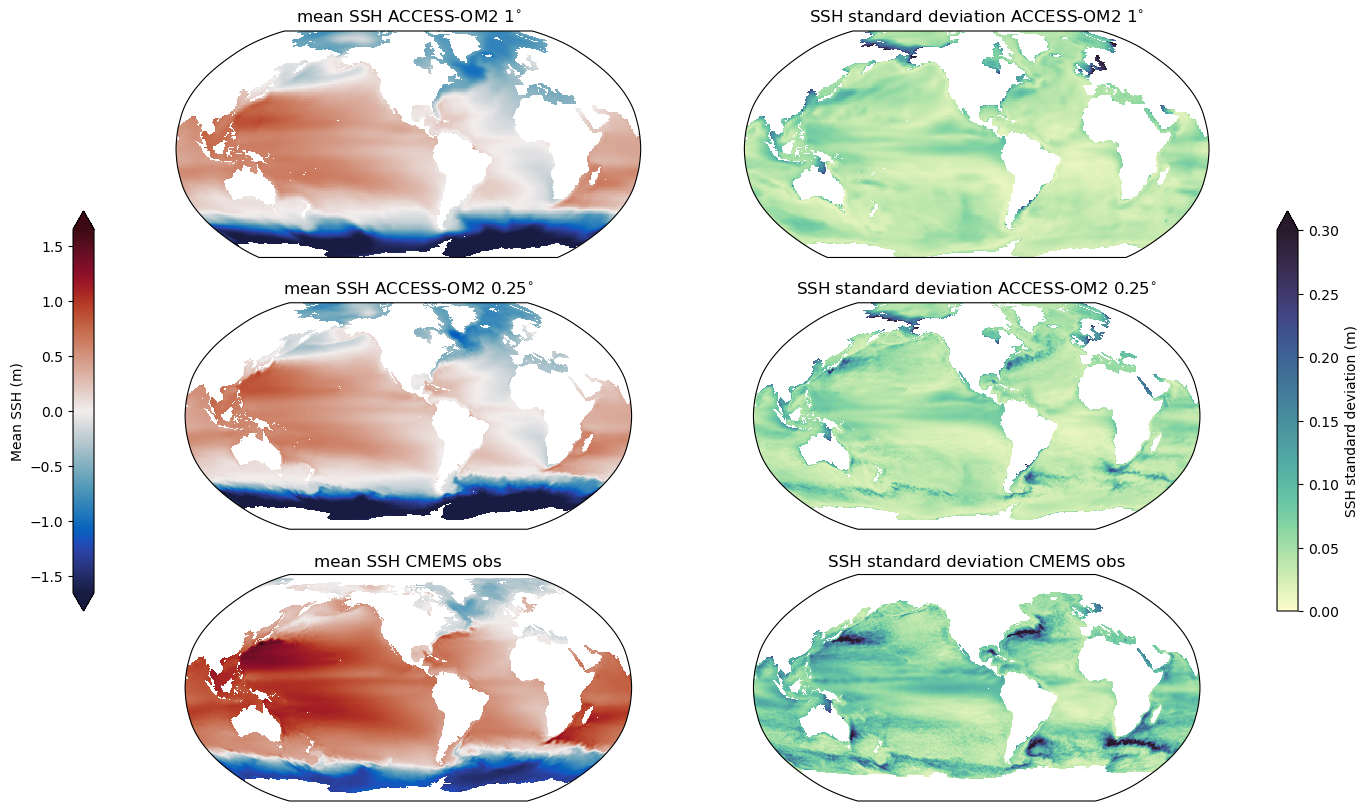

In [11]:
projection = ccrs.Robinson(central_longitude=-100)

fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (14, 10),
                         subplot_kw={'projection': projection})
plt.subplots_adjust(wspace=0.1)

max_std = 0.3
max_mean = 1.65

# mean SSH plots
ax = axes[0, 0]
p1 = ssh1_mean.plot(ax=ax, transform=ccrs.PlateCarree(),
                    cmap=cm.cm.balance, vmin=-max_mean, vmax=max_mean, add_colorbar=False)
ax.set_title('mean SSH ACCESS-OM2 1$^{\circ}$')

ax = axes[1, 0]
p1 = ssh025_mean.plot(ax=ax, transform=ccrs.PlateCarree(),
                      cmap=cm.cm.balance, vmin=-max_mean, vmax=max_mean, add_colorbar=False)
ax.set_title('mean SSH ACCESS-OM2 0.25$^{\circ}$')

ax = axes[2, 0]
p1 = obs_ssh_mean.plot(ax=ax, transform=ccrs.PlateCarree(),
                       cmap=cm.cm.balance, vmin=-max_mean, vmax=max_mean, add_colorbar=False)
ax.set_title('mean SSH CMEMS obs')

# std SSH plots
ax = axes[0, 1]
p2 = ssh1_std.plot(ax=ax, transform=ccrs.PlateCarree(),
                   cmap=cm.cm.deep, vmin=0, vmax=max_std, add_colorbar=False)
ax.set_title('SSH standard deviation ACCESS-OM2 1$^{\circ}$')

ax = axes[1, 1]
p2 = ssh025_std.plot(ax=ax, transform=ccrs.PlateCarree(),
                     cmap=cm.cm.deep, vmin=0, vmax=max_std, add_colorbar=False)
ax.set_title('SSH standard deviation ACCESS-OM2 0.25$^{\circ}$')

ax = axes[2, 1]
p2 = obs_ssh_std.plot(ax=ax, transform=ccrs.PlateCarree(),
                      cmap=cm.cm.deep, vmin=0, vmax=max_std, add_colorbar=False)
ax.set_title('SSH standard deviation CMEMS obs')

# Colorbars
ax_cb1 = plt.axes([0.07, 0.3, 0.015, 0.4])
cb = plt.colorbar(p1, cax=ax_cb1, extend='both', label='Mean SSH (m)')
ax_cb1.yaxis.set_ticks_position('left')
ax_cb1.yaxis.set_label_position('left')

ax_cb2 = plt.axes([0.93, 0.3, 0.015, 0.4])
cb = plt.colorbar(p2, cax=ax_cb2, extend='max', label='SSH standard deviation (m)');

In [12]:
client.close()